_Yue You_

In [6]:
library(ggplot2)
library(survival)
library(dplyr)
library(survminer)
library(reshape2)
rm(list=ls())
setwd("~/Desktop/PH-240/PH-240-Survival-Analysis/hw/hw 1")

# Kalbfleisch & Prentice Exercise 1.1

Consider the mouse carcinogenesis data of Appendix A (data set V). Compute the product limit (Kaplan-Meier) estimates of the survivor function for the endpoint, reticulum cell sarcoma, for the control and germ-free groups by:

### (a) Ignoring failures from thymic lymphoma and other causes 
### (i.e., eliminate mice dying by these causes before carrying out calculations).

summary of data
Type:


Control   GFree 
     99      82 


Cause:


       Other RetCell.Sarc     Thym.Lym 
          77           53           51 


DTime:
range:[ 40 , 1019 ], mean: 514.768 .

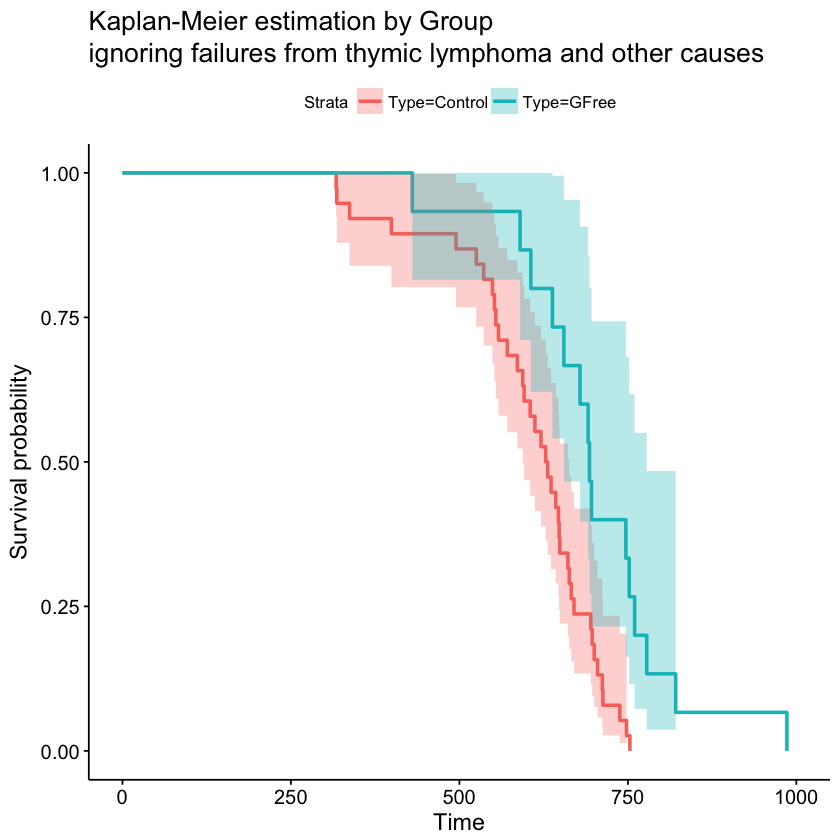

In [7]:
load("data/Dset5.RData")
cat("summary of data")
cat("\nType:")
table(micedf$Type)
cat("\nCause:")
table(micedf$Cause)
cat("\nDTime:")
cat("\nrange:[", range(micedf$DTime)[1], ",", range(micedf$DTime)[2], 
    "], mean:", mean(micedf$DTime),".")

# exclude mice dying by Thym.Lym or other 
mice <- filter(micedf, Cause == "RetCell.Sarc")
km_strata <- survfit(Surv(time = DTime) ~ Type, data = mice, type = "kaplan-meier")

# fit by type, and regardless of type
km_gf <- survfit(Surv(time = DTime) ~ 1, data = mice, 
                 subset = (Type == "GFree"), type = "kaplan-meier")
km_control <- survfit(Surv(time = DTime) ~ 1, data = mice, 
                      subset = (Type == "Control"), type = "kaplan-meier")
km_full <- survfit(Surv(time = DTime) ~ 1, data = mice, type = "kaplan-meier")
fit <- list(GermFree = km_gf, Control = km_control)

# plot
ggsurvplot(km_strata, data = mice, conf.int = TRUE) + 
ggtitle("Kaplan-Meier estimation by Group\nignoring failures
    from thymic lymphoma and other causes")


### (b) Regarding failure times from lymphoma or other causes as right censored.


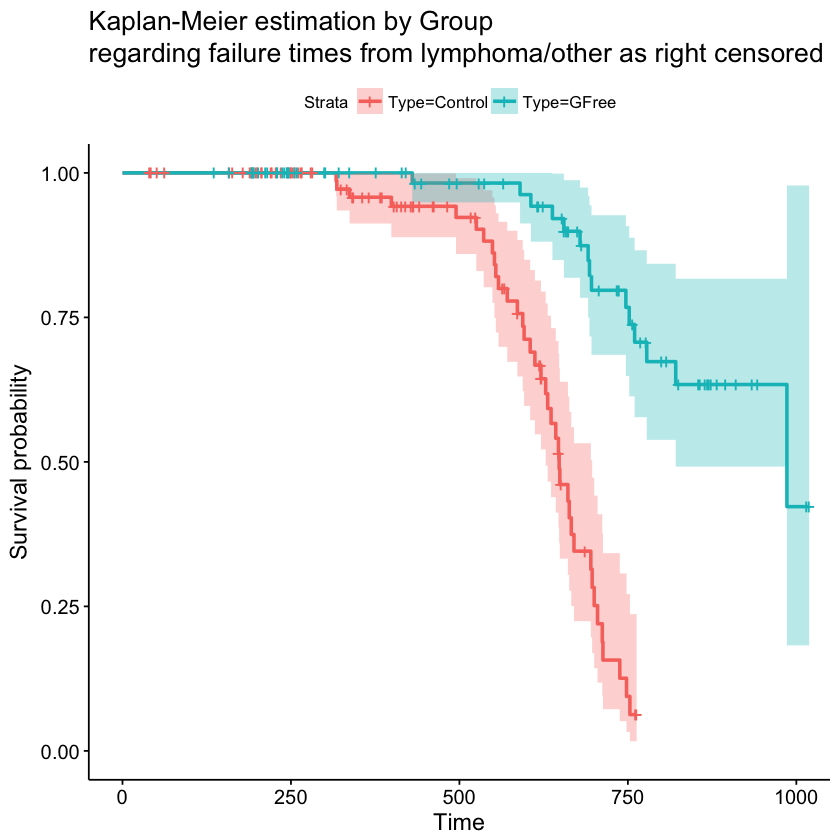

In [8]:
# right censor failure times from lymphoma or other causes
micedf$Delta <- ifelse(micedf$Cause == "RetCell.Sarc", 1, 0)

km_censored <- survfit(Surv(time = DTime, event = Delta, type = "right") ~ Type,
                       data = micedf, type = "kaplan-meier")

ggsurvplot(km_censored, data = micedf, conf.int = TRUE) +
ggtitle("Kaplan-Meier estimation by Group\nregarding failure
    times from lymphoma/other as right censored")


### Comment on the relative merits of parts (a) and (b). (Hint: Try to understand what is being estimated in both cases.) On the basis of the survivor function plots, does the germ-free environment appear to reduce the risk of reticulum cell sarcoma? 

(a)
1. Delete 70% of data, and we're left with sample size(_n_) of 53. The inference based on Central Limit Theorem (_CLT_) can be unreliable due to the small _n_. 
2. T is independent of C. Independence assumption of Kaplan-Meier holds.

(b)
1. Doesn't delete data, and with sample size(_n_) of 181, _CLT_ holds due to large _n_, thus inference based on _CLT_ is reliable.
2. T is **NOT** independent of C, violates Independence assumption of Kaplan-Meier.

Based on plots above, germ-free environment reduces the risk of reticulum cell sarcoma (higher survival rate). 

But due to limitations of our estimator, it might not be true, so germ-free environment might **NOT** actually reduces the risk.


### Regard the simulated distribution in Lab1sol Problem 3 in the Rlabs folder.  Perform a simulation that repeats the following experiment 1000 times: 

### Draw a sample of 1000 iid copies of the observed data distribution and check the coverage of the truth for a 95% confidence interval for the survival probability at time t = 50. 

### Also check simultaneous coverage for times t = 40, 50 and 60. 

Note, simultaneous coverage means every CI covers the corresponding truth. Use the survfit function to obtain the CI's. Briefly comment on the results. 



In [9]:
set.seed(999)
# function of coverage, return = 1 if 95% CI covers truth, return = 0 o.w.
Coverage_At_T <- function(TC = TC, lambda_T = 1/60, C_1 = 2, C_2 = 80){
  n <- 1000
  T <- rexp(n, lambda_T) 
  C <- rweibull(n,C_1,C_2) 
  Ttilde <- pmin(T,C) #observed data 
  Delta <- T < C & T <= 100
  S <- Surv(time = Ttilde, event = Delta, type = "right")
  # estimated survival function based on observed data distribution
  survival <- survfit(S~1, conf.int = .95, type = "kaplan-meier") 
  #estimates
  Sn <- summary(survival,time=TC)$surv 
  #true survival function
  S0 <- 1 - pexp(TC,lambda_T) 
  #lower bound of CIs
  CI_lower <- summary(survival,time=TC)$lower 
  #upper bound of CIs
  CI_upper <- summary(survival,time=TC)$upper 
  Ind_Cover <-  as.numeric(CI_lower <  S0 & CI_upper >  S0)
  return(Ind_Cover)
}

N = 1000
TC = c(40, 50, 60)
# craete empty matrix to store indicators
estimate <- matrix(NA, ncol = length(TC), nrow = N)
for(i in 1:N){
  estimate[i,] <- Coverage_At_T(TC = TC)
}
# individual coverage
Coverage_Mean <- colMeans(estimate)
# print
for(i in 1: length(TC)){
  cat("Coverage of 95% CI for t =", TC[i], "is",
      round(100 * Coverage_Mean[i],2), "%\n")
}
# simultaneous coverage
Coverage_simul <- mean(as.numeric(rowSums(estimate) == 3))
cat("Simultaneous Coverage of 95% CI for t =", TC, "is",
    round(100 * Coverage_simul,2), "%\n")


Coverage of 95% CI for t = 40 is 95 %
Coverage of 95% CI for t = 50 is 95.2 %
Coverage of 95% CI for t = 60 is 95.6 %
Simultaneous Coverage of 95% CI for t = 40 50 60 is 90.5 %


### Comments:

1. 95% CI for individual t = 40, 50, and 60 indeed covers truth at around 95% of time. So individual CI's are reliable.
2. 95% simultaneous CI covers the truth for < 95% of time. So this simultaneous CI is **NOT** reliable. Simultaneous coverage should stem from a multivariate normal distribution with mean = 0 and variance = correlation martix of the covariance matrix.


### Repeat 2 but for the distribution in #6 of Lab1sol.  Briefly comment on the results. 


In [10]:
set.seed(999)
# get the truth
A0 = rbinom(1e6, 1, .5)
T0 = rexp(1e6,(A0*(1/90) + (1/180)))
F0 = ecdf(T0)
# function of coverage, return = 1 if 95% CI covers truth,
# return = 0 o.w.
Coverage_At_T <- function(TC = TC){
  n <- 1000
  A = rbinom(n,1,.5)
  T = rexp(n,(A*(1/90) + (1/180)))
  C = rweibull(n,2,(-A*80 + 120))
  Ttilde <- pmin(T,C) #observed data 
  Delta <- T < C & T <= 100
  S <- Surv(time = Ttilde, event = Delta, type = "right")
  # estimated survival function based on observed data distribution
  survival <- survfit(S~1, conf.int = .95, type = "kaplan-meier") 
  #estimates
  Sn <- summary(survival,time=TC)$surv 
  #true survival function
  S0 <- 1 - F0(TC)
  #lower bound of CIs
  CI_lower <- summary(survival,time=TC)$lower 
  #upper bound of CIs
  CI_upper <- summary(survival,time=TC)$upper 
  Ind_Cover <-  as.numeric(CI_lower <  S0 & CI_upper >  S0)
  return(Ind_Cover)
}

N = 1000
# craete empty matrix to store indicators
estimate <- matrix(NA, ncol = length(TC), nrow = N)
for(i in 1:N){
  estimate[i,] <- Coverage_At_T(TC = c(40, 50, 60))
}
# individual coverage
Coverage_Mean <- colMeans(estimate)
# print
for(i in 1: length(TC)){
  cat("Coverage of 95% CI for t =", TC[i], "is", 
      round(100 * Coverage_Mean[i],2), "%\n")
}
# simultaneous coverage
Coverage_simul <- mean(as.numeric(rowSums(estimate) == 3))
cat("Simultaneous Coverage of 95% CI for t =", TC, "is", 
    round(100 * Coverage_simul,2), "%\n")



Coverage of 95% CI for t = 40 is 73.8 %
Coverage of 95% CI for t = 50 is 49.6 %
Coverage of 95% CI for t = 60 is 24.9 %
Simultaneous Coverage of 95% CI for t = 40 50 60 is 23.9 %


### Comments:
1. Individual coverages are far less than 95%. When time increase, coverage decreases.
2. simultaneous coverage is smaller than all individual coverages, also not reliable.
3. Independence Assumption of T and C in Kaplan-Meier estimator is violated, so we get poor coverage.

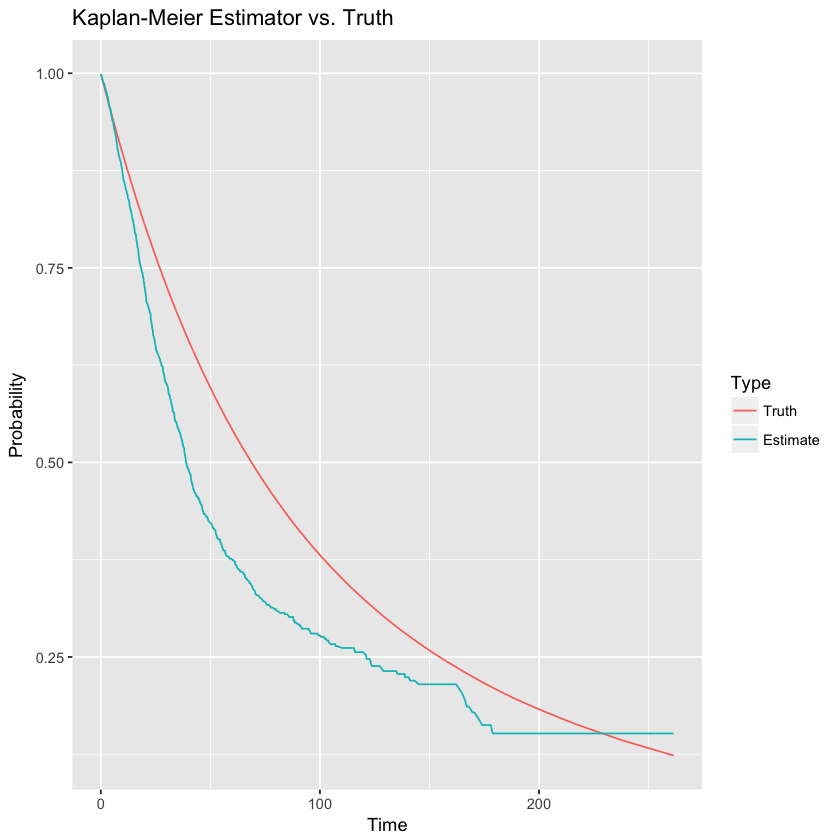

In [12]:
# estimate
n = 1e3
A = rbinom(n,1,.5)
T = rexp(n,(A*(1/90) + (1/180)))
C = rweibull(n,2,(-A*80 + 120))
Ttilde = pmin(C,T)
Delta = T <= C | T <= 100
S <- Surv(time = Ttilde, event = Delta, type = "right")
est_survival <- survfit(S~1, conf.int = .95, type = "kaplan-meier")
# truth
A0 <- rbinom(1e6, 1, .5)
T0 <- rexp(1e6,(A0*(1/90) + (1/180)))
F0 <- ecdf(T0)
S0 <- function(t) 1 - F0(t)
true_survival <- S0(est_survival$time)

df <- melt(data.frame(Truth = true_survival, Estimate = est_survival$surv, 
                      Time = est_survival$time), id="Time")
df <- data.frame(Time=df$Time, Type=df$variable, Probability = df$value)
ggplot(df, aes(x = Time, y = Probability, color = Type)) + geom_line() +
    ggtitle("Kaplan-Meier Estimator vs. Truth") 
